## Predicting the Sale Price of Bulldozers using Machine Learning

***Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.***

**1. Problem Definition**

> `The Target`: **predicting** the sale price of bulldozers sold at auctions.

**2. Data**

* Meaning of data files:
    * **`Train.csv`** is the training set, which contains data through the `end of 2011`.
    
    * **`Valid.csv`** is the validation set, which contains data from `January 1, 2012 - April 30, 2012` You make `predictions` on this set throughout the `majority of the competition`. Your score on this set is used to create the `public leaderboard`.
    
    * **`Test.csv`** is the test set, which won't be released until the `last week of the competition`. It contains data from `May 1, 2012 - November 2012`. Your score on the test set determines your `final rank` for the competition.
    
    
* The key fields are in train.csv are:
    * **`SalesID`**: the uniue identifier of the sale
    * **`MachineID`**: the unique identifier of a machine.  A machine can be sold multiple times
    * **`saleprice`**: what the machine sold for at auction (only provided in train.csv)
    * **`saledate`**: the date of the sale

**3. Evaluation**

> **`RMSLE`(root mean squared log error)**: get this value as low as possible

* Submission files should be formatted as follows:

    * Have a header: "SalesID,SalePrice"
    * Contain two columns
        * `SalesID`: SalesID for the validation set in sorted order
        * `SalePrice`: Your predicted price of the sale

**4. Features**

   ***data dictionary for first look at values:***

* `53 unique columns`

* Dictionary can be found:
https://docs.google.com/spreadsheets/d/1hIMNJzXu1U5u4-DSFAU_uFAGvrWSciF5/edit?usp=sharing&ouid=104502734380757905998&rtpof=true&sd=true

In [ ]:
!cp kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c bluebook-for-bulldozers

 81% 39.0M/48.4M [00:00<00:00, 114MB/s]
100% 48.4M/48.4M [00:00<00:00, 121MB/s]


In [ ]:
!unzip bluebook-for-bulldozers.zip -d data

Archive:  bluebook-for-bulldozers.zip
  inflating: data/Data Dictionary.xlsx  
  inflating: data/Machine_Appendix.csv  
  inflating: data/Test.csv           
  inflating: data/Train.7z           
  inflating: data/Train.zip          
  inflating: data/TrainAndValid.7z   
  inflating: data/TrainAndValid.csv  
  inflating: data/TrainAndValid.zip  
  inflating: data/Valid.7z           
  inflating: data/Valid.csv          
  inflating: data/Valid.zip          
  inflating: data/ValidSolution.csv  
  inflating: data/median_benchmark.csv  
  inflating: data/random_forest_benchmark_test.csv  


In [ ]:
# import data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning models
from sklearn.ensemble import RandomForestRegressor

# import evaluation metrics
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# import hyperparameters
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# save and load model
from joblib import dump, load

In [ ]:
# Import the training and validation set
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [ ]:
# type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [ ]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [ ]:
df.saledate.dtype

dtype('O')

#### Parsing dates with datetime object

In [ ]:
# import data with parse dates
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [ ]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

In [ ]:
df.saledate.dtype

dtype('<M8[ns]')

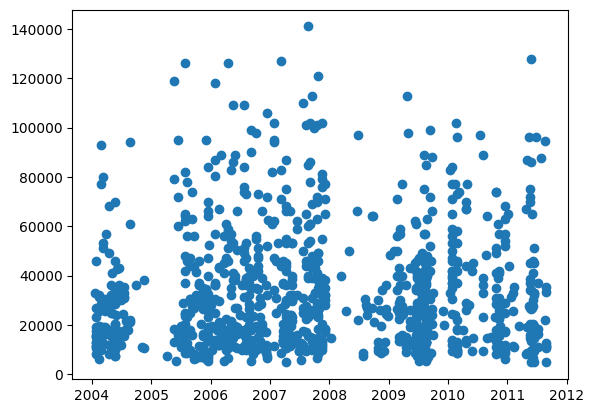

In [ ]:
# plot saledate vs saleprice
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

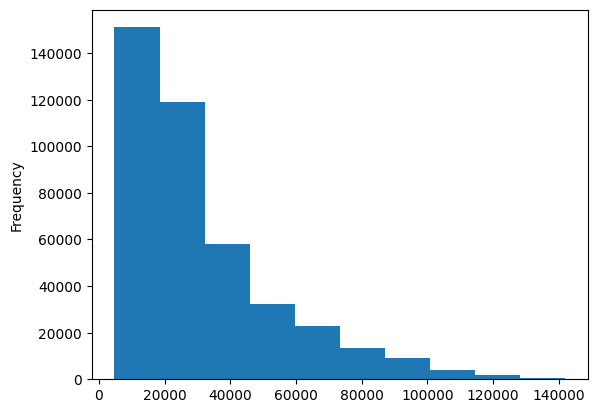

In [ ]:
# level of price values
df.SalePrice.plot.hist();

In [ ]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [ ]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

#### Sort DataFrame by saledate

In [ ]:
# sort DateFrame in the order
df.sort_values(by=["saledate"],
               inplace=True,
               ascending=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

#### make copy of the original DataFrame to play around with no issue

In [ ]:
df_tmp = df.copy()
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


#### Feature Engineering

Split saledate column to `Year`, `Month`, `Day`, `Dayofweek`, `Dayofyear`

In [ ]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# no need saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [ ]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [ ]:
# missing values
df_tmp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

**All Column values must be numeric to build Model**

#### `Convert strings to categories`

In [ ]:
# find columns with strings and then conver to category
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
         df_tmp[label] = content.astype("category").cat.as_ordered()

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [ ]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [ ]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [ ]:
# pandas turns it as integer in index part of category
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [ ]:
# ratio of missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

#### Save Preprocessed Data

In [ ]:
# # export current df_tmp dataframe
df_tmp.to_csv("data/TrainAndValid_tmp.csv", index=False)

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [ ]:
# missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

#### Fill missing values

`For Model`:
* Data has to be numerical
* cannot be any missing values

#### Filling numerical values first

fill any column with missing values with median of that column

In [ ]:
# numeric columns
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [ ]:
# which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [ ]:
# fill missing numeric values with median
for label, content in df_tmp.items() :
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # add binary column if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [ ]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [ ]:
# any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [ ]:
# missing values in auctioneerID
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [ ]:
# missing values in MachineHoursCurrentMeter
df_tmp.MachineHoursCurrentMeter_is_missing.value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

In [ ]:
# missing values in non-numeric columns
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

#### Flling and turning categorical variables to numbers

In [ ]:
# columns with non-numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [ ]:
# turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    # columns with non-numeric
    if not pd.api.types.is_numeric_dtype(content):
        # add binary column to inidicate missing or not
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # pandas encodes missing categories as -1 so add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 81.1 MB


In [ ]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [ ]:
# sort DateFrame in the order
df_tmp.sort_values(by=["SalesID"],
               inplace=True,
               ascending=True)
df_tmp.SalesID.head(10)

0    1139246
1    1139248
2    1139249
3    1139251
4    1139253
5    1139255
6    1139256
7    1139261
8    1139272
9    1139275
Name: SalesID, dtype: int64

In [ ]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,True
Blade_Type_is_missing,True,True,True,True,True
Travel_Controls_is_missing,True,True,True,True,True
Differential_Type_is_missing,False,False,True,True,True


***has been cleaned all missing values for numerical, non-numerical columns, ready to `build model`.***

### Machine `Supervised` Learning `Model`

In [ ]:
%%time

# instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# fit the model
model.fit(df_tmp.drop("SalePrice", axis=1)[:100], df_tmp["SalePrice"][:100])

CPU times: user 676 ms, sys: 29.9 ms, total: 706 ms
Wall time: 1.03 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# score the mode
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.22083179647675832

> that **score** in evaluated on `train set`, so we need to do this for `test set` which is never seen before.

* **Key Points**
    * cannot split data randomly using `train_test_split()` because It is time-series and they requested files as per date.

    * **what is requested**
        * **`Training`** = all samples up until 2011
        * **`Valid`** = all samples form January 1, 2012 - April 30, 2012
        * **`Test`** = all samples from May 1, 2012 - November 2012

In [ ]:
# custom validation set
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [ ]:
# split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [ ]:
# split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

* find pattern with X_train, y_train
* apply pattern to X_valid, y_valid

#### Building an evaluation function

> **requested**: root mean squared log error `RMSLE`

* **`RMSLE`**: Scikit-Learn has `MSLE` mean_squared_log_error, same logic plus calculate root.

**Other metrics**:

* `MSE` mean absolute error: exact differences.
* `R^2`: default score

In [ ]:
# evaluation function "using RMSLE as per competition"
def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error between predictions
    and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# evaluate model for each levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

### Testing model on a subset "to tune the hyperparameters"
#### reduce the time for modeling

> Alter number of samples each `n_estimator` in the `RandomForestRegressor`, using **`max_samples`**

* **`max_samples`**: set random data to use, "use `10000` instead of `400000`" in order to `reduce time` for modeling.

In [ ]:
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [ ]:
%%time
model.fit(X_train, y_train)

CPU times: user 43.5 s, sys: 392 ms, total: 43.9 s
Wall time: 26.2 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [ ]:
# calculate custome evaluating metrics
show_scores(model)

{'Training MAE': 5554.061618822063,
 'Valid MAE': 7139.615822172297,
 'Training RMSLE': 0.25758465681614984,
 'Valid RMSLE': 0.29248380187626777,
 'Training R^2': 0.8608402371243158,
 'Valid R^2': 0.83308596217853}

***tune hyperparameters with this base_model***

### Hyperparameter tuning with RandomizedSearchCV

In [ ]:
%%time
# constant of hyperparameters
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 11)]

# Number of features to consider at every split
max_features = ['sqrt', 0.5, 1]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 110, num = 3)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 110, num = 3)]

# hyperparameters
rf_grid ={'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'max_samples': [50000]}

# instantiate randomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=10,
                              cv=5,
                              random_state=42,
                              verbose=True,
                              n_jobs=-1)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 1min 11s, sys: 3.06 s, total: 1min 14s
Wall time: 13min 43s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 0.5, 1],
                                        'max_samples': [50000],
                                        'min_samples_leaf': [1, 55, 110],
                                        'min_samples_split': [2, 56, 110],
                                        'n_estimators': [10, 19, 28, 37, 46, 55,
                                                         64, 73, 82, 91, 100]},
                   random_state=42, verbose=True)

In [ ]:
# best parameters from the RandomizedSearch
rs_model_param = rs_model.best_params_
rs_model_param

{'n_estimators': 73,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 50000,
 'max_features': 0.5,
 'max_depth': 50}

In [ ]:
# evaluate it
show_scores(rs_model)

{'Training MAE': 4347.757356703676,
 'Valid MAE': 6312.954830622527,
 'Training RMSLE': 0.20751903910789501,
 'Valid RMSLE': 0.2619734351524556,
 'Training R^2': 0.9130640802127339,
 'Valid R^2': 0.8695879743768427}

***found best parameters using 50000 samples, The parameters can be used for GridSearchCV with low samples***

* After tune hyperparameters for final, estimators leaf and split in below

### Train a model with te best parameters

In [ ]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=415,
                                    min_samples_leaf=3,
                                    min_samples_split=3,
                                    max_depth=None,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)
ideal_model.fit(X_train, y_train)
show_scores(ideal_model)

CPU times: user 36min 1s, sys: 9.26 s, total: 36min 10s
Wall time: 20min 15s


{'Training MAE': 2488.742126732406,
 'Valid MAE': 5869.015597725507,
 'Training RMSLE': 0.12704334985953225,
 'Valid RMSLE': 0.24165890771118576,
 'Training R^2': 0.9685693080362118,
 'Valid R^2': 0.8839956699939224}

> RMSLE: **`0.2416`**, It is on top 24.

## Get Ready for Submission
### Make Predictions on Test Data

* Submission files should be formatted as follows:

    * Have a header: "SalesID,SalePrice"
    * Contain two columns
        * `SalesID`: SalesID for the validation set in sorted order
        * `SalePrice`: Your predicted price of the sale

In [ ]:
# import the test data
df_test = pd.read_csv("data/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data

**data manipulation for test data set as same as did training data set**

In [ ]:
# function for preprocess
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # drop original saledata
    df.drop("saledate", axis=1, inplace=True)

    # fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())

        # fill categorical missing data
        # turn categories variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # added +1, pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1

    return df

In [ ]:
# process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [ ]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,999089,3157,121,3.0,2004,68.0,2,963,298,...,True,True,True,True,True,True,True,True,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1745,529,...,True,True,True,True,True,True,True,True,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,336,111,...,True,True,True,True,True,True,True,True,True,True
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3716,1381,...,True,True,True,True,True,True,True,True,True,True
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4261,1538,...,True,True,True,True,True,True,True,True,True,True


* `test data`: 5 rows × 101 columns
* `train data`:5 rows × 102 columns
> Columns must be same to make predictions

In [ ]:
# find different column using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [ ]:
# manually adding auctioneerID_is_missing to df_test
df_test["auctioneerID_is_missing"] = False
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True
Steering_Controls_is_missing,True,False,True,True,True


In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [ ]:
test_preds

array([19416.05358456, 19829.45986193, 48990.20316564, ...,
       14639.59746178, 20475.88228171, 30866.46098547])

In [ ]:
# Format predictions as per requested format
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,19416.053585
1,1227844,19829.459862
2,1227847,48990.203166
3,1227848,65113.492150
4,1227863,44501.446468
...,...,...
12452,6643171,45674.279306
12453,6643173,16125.231263
12454,6643184,14639.597462
12455,6643186,20475.882282


In [ ]:
# Export submission data
df_preds.to_csv("submission/test_predictions.csv", index=False)

### Save/Load Model

`joblib`

In [ ]:
# save model to file
dump(ideal_model, filename="model/bulldozers_RandomForestRegression_model_1.joblib")

['model/bulldozers_RandomForestRegression_model_1.joblib']

In [ ]:
# load saved model
load_model = load(filename="model/bulldozers_RandomForestRegression_model_1.joblib")

In [ ]:
# predictions on test data
joblib_df_preds = load_model.predict(df_test)

In [ ]:
# dataframe for submission
test_submission = pd.DataFrame({'SalesID': df_test["SalesID"], 'SalesPrice': joblib_df_preds})
test_submission

,SalesID,SalesPrice
0,1227829,19416.053585
1,1227844,19829.459862
2,1227847,48990.203166
3,1227848,65113.492150
4,1227863,44501.446468
...,...,...
12452,6643171,45674.279306
12453,6643173,16125.231263
12454,6643184,14639.597462
12455,6643186,20475.882282


In [ ]:
# create submission file
test_submission.to_csv("submission/joblib_test_predictions.csv", index=False)

### Feature Importance

> **`Feature importance`** seeks to figure out which different attributes of the data were most important when it comes to predicting the `target variable`.

**Key Points**
* `Default feature importances` for random forest can lead to non-ideal results.
* `feature_importances_` attribute can be used to find them.

In [ ]:
# find feature importance of our best model "using saved model"
load_model.feature_importances_

array([3.49883048e-02, 2.11070545e-02, 4.27216600e-02, 1.95105729e-03,
       3.79770984e-03, 1.95199830e-01, 3.28838282e-03, 1.14945501e-03,
       4.19999436e-02, 4.58777074e-02, 6.65346424e-02, 4.80244908e-03,
       2.00803412e-02, 1.49228446e-01, 4.38986030e-02, 7.17327999e-03,
       3.03654691e-03, 2.22494597e-03, 3.32707164e-03, 6.52930171e-02,
       4.59468163e-04, 1.85762064e-04, 1.00634624e-03, 2.35213822e-04,
       1.35751061e-03, 4.27715001e-05, 1.87963828e-03, 6.83508978e-03,
       1.55495459e-03, 1.57747413e-03, 3.71913839e-03, 2.87385548e-03,
       4.00752670e-03, 1.43006129e-03, 1.33730848e-03, 1.03158653e-02,
       9.67506866e-04, 1.23820563e-02, 1.57325632e-03, 2.12675413e-03,
       1.40971628e-03, 9.66175491e-04, 2.79367713e-03, 6.42108217e-04,
       5.64423441e-04, 3.65977697e-04, 4.24193993e-04, 2.35522621e-03,
       1.05771815e-03, 2.65239993e-04, 2.99018318e-04, 7.37527048e-02,
       4.95667941e-03, 7.29199475e-03, 3.66209484e-03, 1.12572074e-02,
      

***Visualize top 20 values***

In [ ]:
# helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))

    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

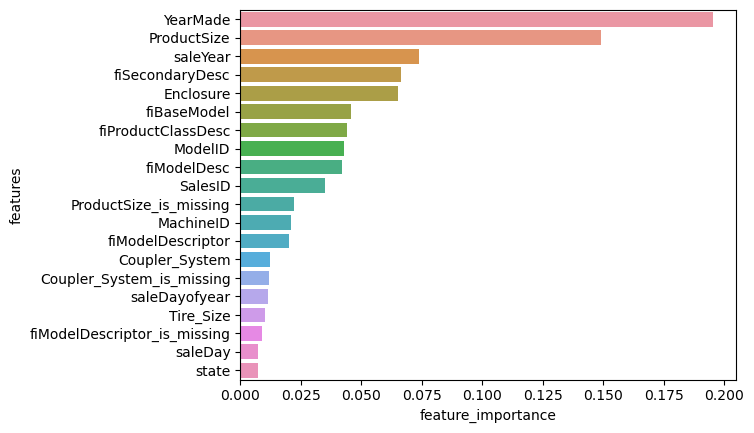

In [ ]:
plot_features(X_train.columns, load_model.feature_importances_)

In [ ]:
sum(load_model.feature_importances_)

0.9999999999999994

In [ ]:
df.ProductSize.isna().sum()

216605

In [ ]:
df.ProductSize.value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [ ]:
# Return a Series containing counts of unique values
df.Turbocharged.value_counts()

None or Unspecified    77111
Yes                     3985
Name: Turbocharged, dtype: int64

In [ ]:
df.Thumb.value_counts()

None or Unspecified    85074
Manual                  9678
Hydraulic               7580
Name: Thumb, dtype: int64